In [ ]:
!pip install kagglehub tensorflow pandas numpy matplotlib gradio transformers pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 22.3 MB/s eta 0:00:00


In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import gradio as gr

In [ ]:
print(tf.__version__)

2.18.0


In [ ]:
import gradio as gr
print(gr.__version__)


5.29.0


In [ ]:
print(np.__version__)

2.0.2


In [ ]:
# Download the Indiana Chest X-ray dataset using Kaggle Hub
path = kagglehub.dataset_download("raddar/chest-xrays-indiana-university")
print("Dataset downloaded to:", path)

Dataset downloaded to: /kaggle/input/chest-xrays-indiana-university


In [ ]:
# Load the CSV files

projections = pd.read_csv(f"/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv")  #/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv
reports = pd.read_csv(f"/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv")

# Merge projections and reports by 'uid'
data = pd.merge(projections, reports, on="uid")
data.head()

,uid,filename,projection,MeSH,Problems,image,indication,comparison,findings,impression
0,1,1_IM-0001-4001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,1,1_IM-0001-3001.dcm.png,Lateral,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
2,2,2_IM-0652-1001.dcm.png,Frontal,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
3,2,2_IM-0652-2001.dcm.png,Lateral,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
4,3,3_IM-1384-1001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."


In [ ]:
import pandas as pd

csv_path = "/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv"
df = pd.read_csv(csv_path)

print("Columns in CSV:")
print(df.columns)

Columns in CSV:
Index(['uid', 'MeSH', 'Problems', 'image', 'indication', 'comparison',
       'findings', 'impression'],
      dtype='object')


In [ ]:
import pandas as pd

# Load CSVs
projections = pd.read_csv("/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv")
reports = pd.read_csv("/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv")

# Clean column names
projections.columns = projections.columns.str.strip().str.lower()
reports.columns = reports.columns.str.strip().str.lower()

# Check column names exist
assert "uid" in projections.columns and "uid" in reports.columns
assert "problems" in reports.columns

# Merge on 'uid'
df = pd.merge(projections, reports, on="uid")

# Drop rows with missing 'problems'
df = df.dropna(subset=["problems"])

In [ ]:
import pandas as pd
import os

# Paths
image_dir = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized"
projections_path = "/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv"
reports_path = "/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv"

# Load CSVs
projections = pd.read_csv(projections_path)
reports = pd.read_csv(reports_path)

# Merge on uid
df = pd.merge(projections, reports, on="uid")

# Create mapping from filename suffix to full path
image_files = os.listdir(image_dir)
suffix_to_path = {img.split("_", 1)[1]: os.path.join(image_dir, img) for img in image_files if "_" in img}

# Extract suffix from the 'filename' column
df["filename_suffix"] = df["filename"].apply(lambda x: x.split("_", 1)[1])

# Map suffix to actual path
df["image_path"] = df["filename_suffix"].map(suffix_to_path)

# Drop rows where mapping failed
df = df.dropna(subset=["image_path"])

print("✅ Total usable images after matching:", len(df))
print("🩻 Sample mapped image path:", df["image_path"].iloc[0])
print("🩺 Sample label:", df['Problems'].iloc[0] if 'Problems' in df.columns else "No label column")

✅ Total usable images after matching: 7466
🩻 Sample mapped image path: /kaggle/input/chest-xrays-indiana-university/images/images_normalized/1_IM-0001-4001.dcm.png
🩺 Sample label: normal


In [ ]:
!pip install joblib

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# Step 1: Clean and split multi-label text
df['Problems'] = df['Problems'].fillna('')
df['label_list'] = df['Problems'].apply(lambda x: x.lower().split('|'))  # Split by '|'

# Step 2: Binarize labels into multi-hot format
mlb = MultiLabelBinarizer()
label_matrix = mlb.fit_transform(df['label_list'])

# Optional: Save class names
class_labels = mlb.classes_
print(f"✅ Total unique disease classes: {len(class_labels)}")

# Step 3: Train-test split
from sklearn.model_selection import train_test_split

image_paths = df['image_path'].values
y = label_matrix

train_paths, val_paths, y_train, y_val = train_test_split(image_paths, y, test_size=0.2, random_state=42)

print(f"✅ Train shape: {y_train.shape}, Validation shape: {y_val.shape}")

✅ Total unique disease classes: 1430
✅ Train shape: (5972, 1430), Validation shape: (1494, 1430)


In [ ]:
num_classes = len(mlb.classes_)  # From MultiLabelBinarizer

In [ ]:
import joblib
from google.colab import drive
drive.mount('/content/drive')

joblib.dump(mlb, '/content/drive/MyDrive/mlb_classes.pkl')
print(" mlb saved!")

Mounted at /content/drive
 mlb saved!


In [ ]:
import joblib

mlb = joblib.load('/content/drive/MyDrive/mlb_classes.pkl')
class_labels = mlb.classes_

print(f"🔁 Loaded mlbw with {len(class_labels)} classes")

🔁 Loaded mlbw with 1430 classes


In [ ]:
print("Total number of X-ray images:", len(df))
print("Number of unique disease labels:", len(mlb.classes_))


Total number of X-ray images: 7466
Number of unique disease labels: 1430


<ipython-input-13-7fb729a92c82>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_counts.index[:30], y=sorted_counts.values[:30], palette="viridis")


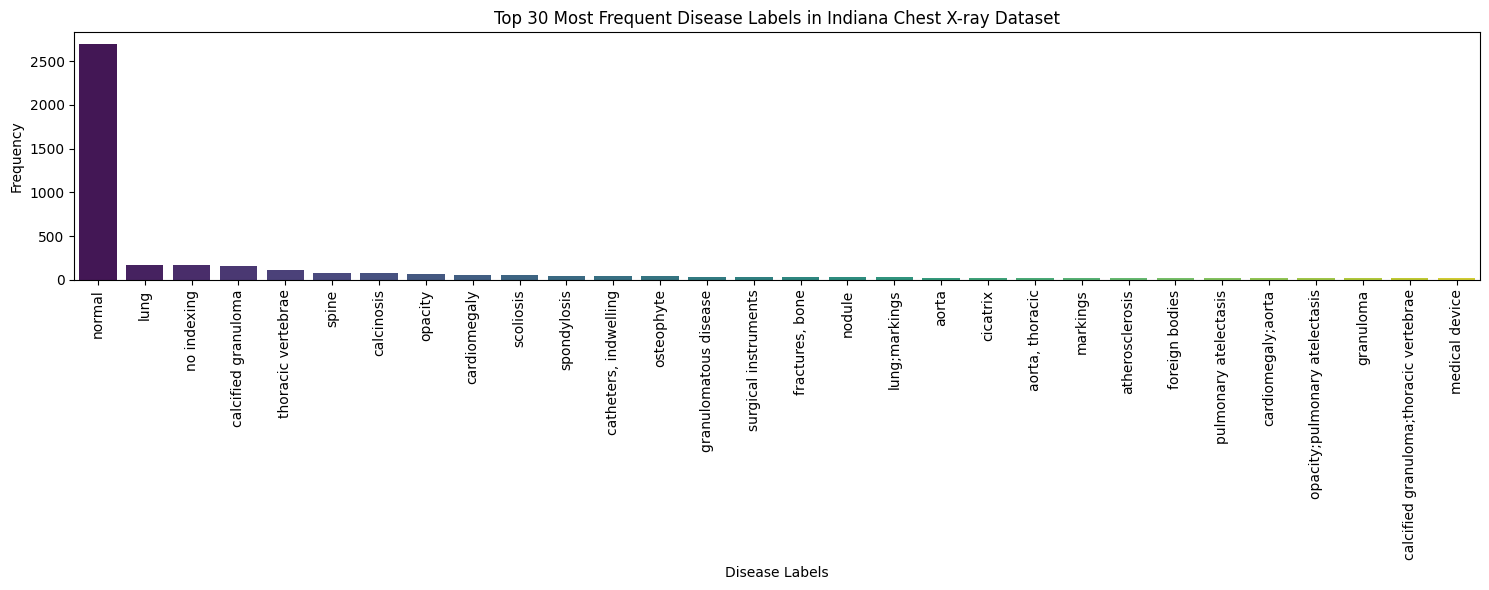

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

label_counts = label_matrix.sum(axis=0)
sorted_counts = pd.Series(label_counts, index=mlb.classes_).sort_values(ascending=False)

plt.figure(figsize=(15, 6))
sns.barplot(x=sorted_counts.index[:30], y=sorted_counts.values[:30], palette="viridis")
plt.title("Top 30 Most Frequent Disease Labels in Indiana Chest X-ray Dataset")
plt.xlabel("Disease Labels")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


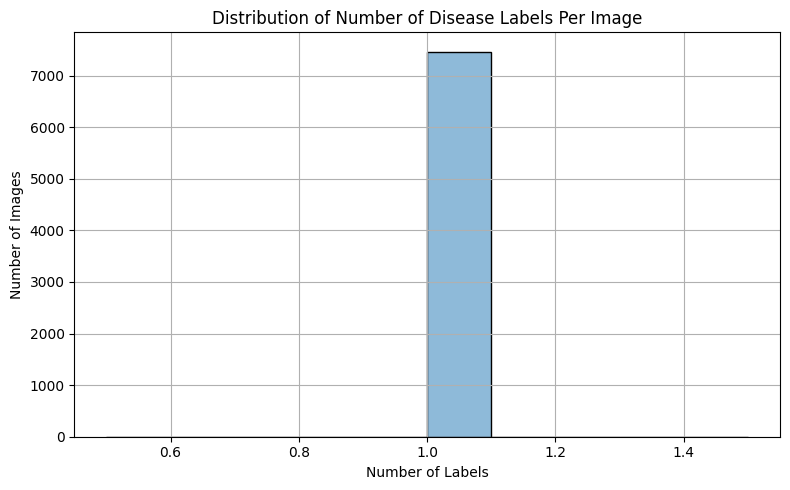

In [ ]:
label_counts_per_image = label_matrix.sum(axis=1)

plt.figure(figsize=(8, 5))
sns.histplot(label_counts_per_image, bins=10, kde=True)
plt.title("Distribution of Number of Disease Labels Per Image")
plt.xlabel("Number of Labels")
plt.ylabel("Number of Images")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-18-e84a6e3ab737>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=projection_counts.index, y=projection_counts.values, palette="coolwarm")


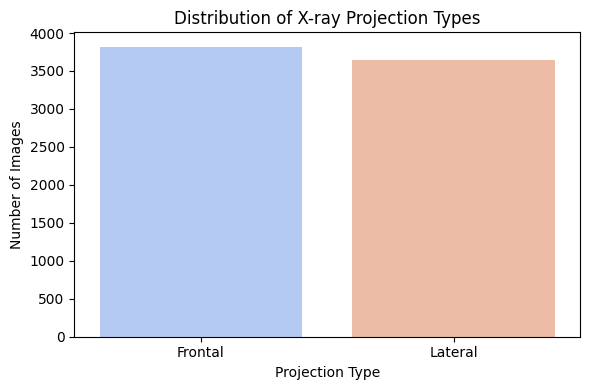

In [ ]:
projection_counts = df['projection'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=projection_counts.index, y=projection_counts.values, palette="coolwarm")
plt.title("Distribution of X-ray Projection Types")
plt.xlabel("Projection Type")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np

sample_paths = df['image_path'].sample(100).tolist()
shapes = [cv2.imread(p, cv2.IMREAD_GRAYSCALE).shape for p in sample_paths]

height_stats = [h for h, w in shapes]
width_stats = [w for h, w in shapes]

print("Average Image Height:", np.mean(height_stats))
print("Average Image Width:", np.mean(width_stats))


Average Image Height: 2209.23
Average Image Width: 2156.45


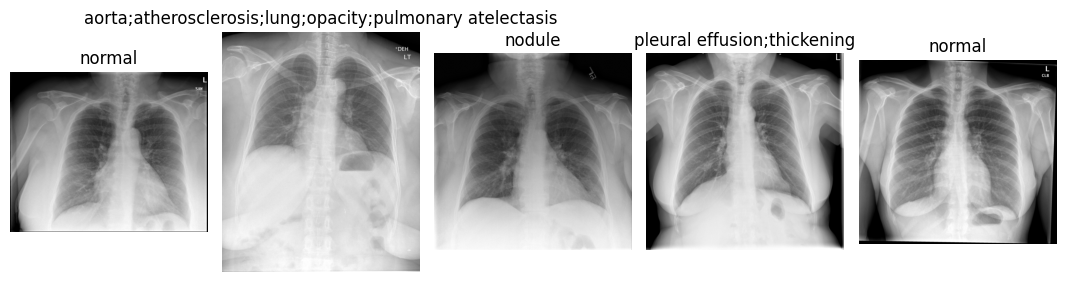

In [ ]:
import matplotlib.pyplot as plt

sample = df.sample(5)
plt.figure(figsize=(15, 5))
for i, row in enumerate(sample.itertuples()):
    img = cv2.imread(row.image_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, 7, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title("\n".join(row.label_list))
    plt.axis('off')
plt.tight_layout()
plt.show()


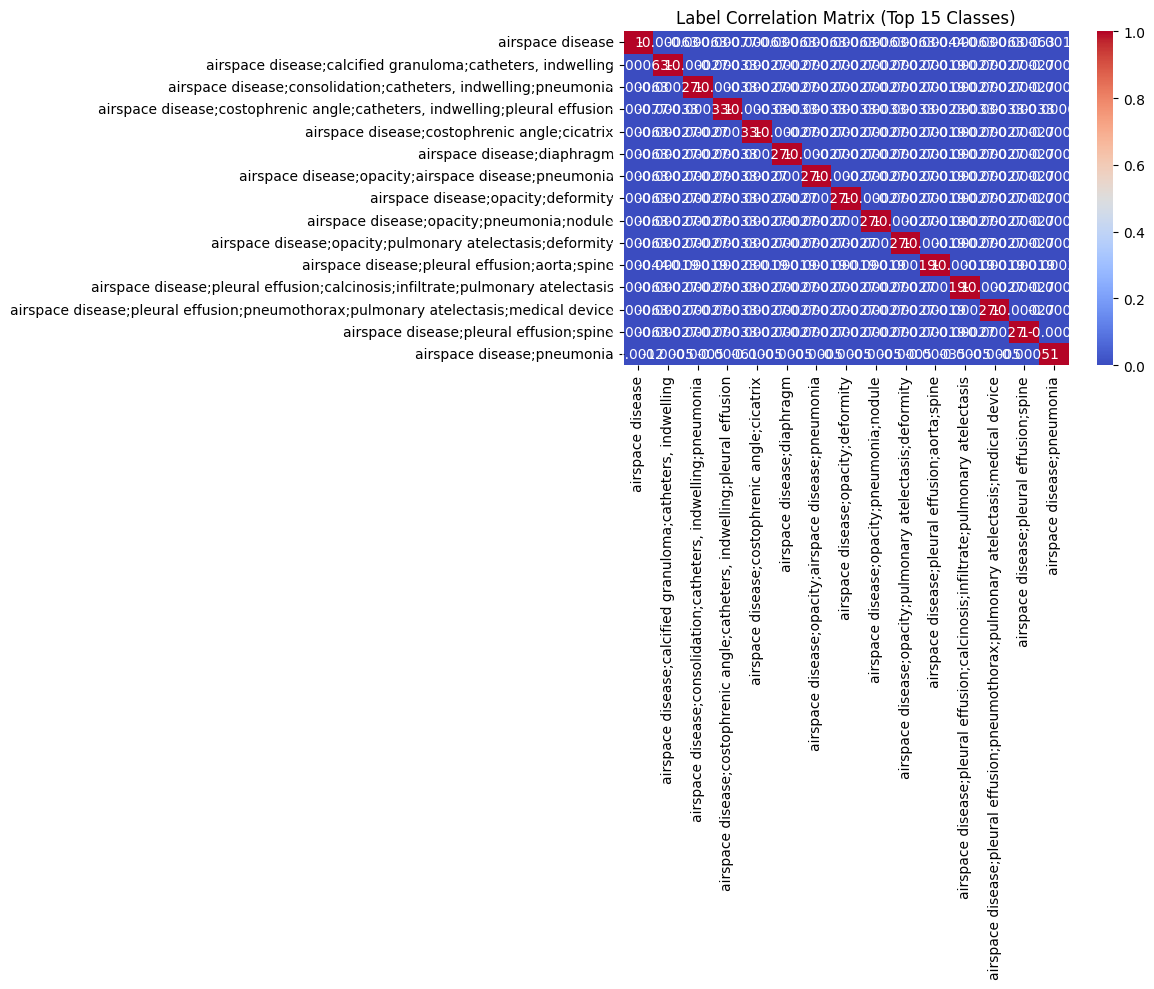

In [ ]:
import numpy as np

corr_matrix = np.corrcoef(label_matrix.T)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix[:15, :15], xticklabels=mlb.classes_[:15], yticklabels=mlb.classes_[:15], cmap="coolwarm", annot=True)
plt.title("Label Correlation Matrix (Top 15 Classes)")
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf

IMG_SIZE = 256  # For consistency with your model's expected input size

def process_image(path, label):
    # Read and decode the image
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)  # Decode as RGB (3 channels)

    # Resize image to match the expected input size for the model
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])  # Resize to 256x256

    # Normalize image to [0, 1] range
    image = tf.cast(image, tf.float32) / 255.0

    # Ensure label is in the correct data type (float32 for binary_crossentropy)
    label = tf.cast(label, tf.float32)

    return image, label

def create_dataset(image_paths, labels, batch_size=32):
    # Convert labels to tensors if they are not already
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)

    # Create a TensorFlow dataset from image paths and labels
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)

    # Combine both datasets
    ds = tf.data.Dataset.zip((path_ds, label_ds))

    # Map the image processing function to each element of the dataset
    ds = ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle, batch, and prefetch the dataset for better performance
    ds = ds.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return ds

# Assuming train_paths and y_train are lists of image file paths and their corresponding labels
# Create the training and validation datasets
train_dataset = create_dataset(train_paths, y_train)
val_dataset = create_dataset(val_paths, y_val)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

In [ ]:
import tensorflow.keras.backend as K

def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)
        pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        return -K.mean(alpha * K.pow(1. - pt, gamma) * K.log(pt))
    return loss_fn

In [ ]:
from tensorflow.keras.applications import DenseNet121

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
output = Dense(num_classes, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=focal_loss(gamma=2., alpha=0.25),
              metrics=['accuracy', AUC(name='auc'), Precision(), Recall()])

In [ ]:
early_stop = EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss')

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=10,
                    callbacks=[early_stop])

In [ ]:
# Unfreeze some layers
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss=focal_loss(gamma=2., alpha=0.25),
              metrics=['accuracy', AUC(name='auc'), Precision(), Recall()])

history_finetune = model.fit(train_dataset,
                             validation_data=val_dataset,
                             epochs=5,
                             callbacks=[early_stop])

In [ ]:
for img, label in val_dataset.take(1):
    print("Label shape:", label.shape)
    print("Label vector (first sample):", label.numpy()[0])
    print("Sum of labels in this sample:", np.sum(label.numpy()[0]))

Label shape: (32, 1430)
Label vector (first sample): [0. 0. 0. ... 0. 0. 0.]
Sum of labels in this sample: 1.0


In [ ]:
#correct one
from sklearn.metrics import precision_recall_curve, average_precision_score

# Initialize lists for plotting
precision_all = []
recall_all = []
ap_score_all = []

# For each class, compute PR curve and AP score
for i in range(y_true.shape[1]):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
    ap_score = average_precision_score(y_true[:, i], y_probs[:, i])

    precision_all.append(precision)
    recall_all.append(recall)
    ap_score_all.append(ap_score)

    # Optionally, plot the PR curve for each class
    plt.plot(recall, precision, label=f'Class {i} (AP={ap_score:.4f})')

# Plot overall PR curve
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Class')
plt.legend()
plt.grid()
plt.show()

# Optionally print average AP score
average_ap_score = np.mean(ap_score_all)
print(f"Average AP Score (across all classes): {average_ap_score:.4f}")

In [ ]:
custom_threshold = 0.2  # you can tune this between 0.1 to 0.5
y_pred = (y_probs > custom_threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, zero_division=0, digits=4))

In [ ]:
output = Dense(1430, activation='sigmoid')(x)

In [ ]:
#model.save("densenet_xray_finetune_model3.keras")
model.save('/content/drive/MyDrive/densenet_xray_finetune_model3.h5')

In [ ]:
from tensorflow.keras.models import load_model

def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -tf.reduce_mean(alpha * tf.pow(1. - pt, gamma) * tf.math.log(pt))
    return loss_fn

model3 = load_model("/content/drive/MyDrive/densenet_xray_finetune_model3.h5", custom_objects={'loss_fn': focal_loss()})

In [ ]:
num_classes = model3.output_shape[-1]
print(f"Number of disease classes in the model: {num_classes}")

Number of disease classes in the model: 1430


In [ ]:
import os
os.listdir('/content/drive/MyDrive')

['fees uucms.jpg',
 'abstract 232026.pdf',
 'abstract 232008.pdf',
 'Fees receipt 2024',
 'sample_data.csv',
 'wiki1.txt',
 "I am sharing 'SOCIAL MEDIA SENTIMENT ANALYSIS' with you",
 'Blog generation using Llama 2',
 "I am sharing 'Copy of Tcs BDA(Dec batch)(1).xlsx' with you from WPS Office",
 ' SENTIMENT ANALYSIS OF SOCIAL MEDIA',
 '8 Certificate ',
 'all_stocks_5yr.csv',
 'Chaitra Plagiarism Report 02 Dec 24.pdf',
 'TCS(dec batch students) .xlsx',
 '232008ChaitraB.pdf',
 'hall-ticket.pdf',
 'resume_Chaitra B',
 'Colab Notebooks',
 'resnet_disease_classifier.h5',
 'class_labels.txt',
 'resnet50_xray_model.keras',
 'resnet50_xray_model_finetuned.keras',
 'resnet50_xray_model2.keras',
 'resnet50_xray_model_finetuned2.keras',
 'densenet_xray_finetune_model.h5',
 'densenet_xray_finetune_model.keras',
 'densenet_xray_finetune_model3.h5',
 'mlb_classes.pkl',
 'unet_full_model.h5']

In [ ]:
from google.colab import files

# Open a file dialog to upload files
uploaded = files.upload()

Saving cxr_reg_weights.best.hdf5 to cxr_reg_weights.best.hdf5


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate

# Step 1: Define U-Net architecture for RGB images
def unet(input_size=(256, 256, 3)):  # Changed input size to (256, 256, 3)
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

# Step 2: Build the model
model = unet(input_size=(256, 256, 1))  # Ensuring it's built for RGB images
model.summary()
# Modify your U-Net input shape to (256, 256, 1) instead of (256, 256, 3)
#model = unet(input_size=(256, 256, 1))


# Step 3: Load pretrained weights (ensure you have the correct weights file)
model.load_weights('/content/cxr_reg_weights.best.hdf5')

# ✅ Step 4: Save the full model (architecture + weights)
model.save('/content/drive/MyDrive/unet_full_model.h5')

print("✅ Full U-Net model (architecture + weights) saved successfully.")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    524,544 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

✅ Full U-Net model (architecture + weights) saved successfully.


In [ ]:
from tensorflow.keras.models import load_model
unet_model = load_model('/content/drive/MyDrive/unet_full_model.h5')

In [ ]:
!pip install gradio

In [ ]:
#proper code correct one
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import joblib
from tensorflow.keras.models import load_model
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

# Load models and data
unet_model = load_model('/content/drive/MyDrive/unet_full_model.h5', compile=False)
resnet_model = load_model("/content/drive/MyDrive/densenet_xray_finetune_model3.h5", custom_objects={'loss_fn': focal_loss()})
mlb = joblib.load('/content/drive/MyDrive/mlb_classes.pkl')
class_labels = mlb.classes_
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")

IMG_SIZE = 256
THRESHOLD = 0.2

# --- Lung Segmentation ---
def predict_mask(image):
    image = image.convert("L").resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=(0, -1))  # Shape: (1, 256, 256, 1)
    pred_mask = unet_model.predict(img_array)[0, :, :, 0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255
    return Image.fromarray(pred_mask)

# --- Generate Explanation using GPT-2 ---
def generate_explanation(disease):
    prompt = f"The patient shows signs of {disease}. The medical explanation is:"
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    output_ids = gpt2_model.generate(
        input_ids,
        max_length=100,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        early_stopping=True
    )
    explanation = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return explanation.replace(prompt, "").strip()

# --- Disease Prediction (with Explanation) ---
def predict_diseases(image):
    image = image.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(image) / 255.0
    if img_array.shape[-1] == 4:
        img_array = img_array[..., :3]
    img_array = np.expand_dims(img_array, axis=0)

    preds = resnet_model.predict(img_array)[0]
    pred_indices = np.where(preds >= THRESHOLD)[0]

    if len(pred_indices) == 0:
        return "No disease confidently detected.", ""

    result = {class_labels[i]: float(preds[i]) for i in pred_indices}
    sorted_result = dict(sorted(result.items(), key=lambda x: x[1], reverse=True))

    top_disease = list(sorted_result.keys())[0]
    explanation = generate_explanation(top_disease)

    return sorted_result, f"**{top_disease}**: {explanation}"

# --- Top 3 Disease Prediction (No Explanation) ---
def predict_top3_diseases(image):
    image = image.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(image) / 255.0
    if img_array.shape[-1] == 4:
        img_array = img_array[..., :3]
    img_array = np.expand_dims(img_array, axis=0)

    preds = resnet_model.predict(img_array)[0]

    # Get top 3 predictions regardless of threshold
    top_3_indices = np.argsort(preds)[-3:][::-1]
    top_3 = {class_labels[i]: round(float(preds[i]), 3) for i in top_3_indices}

    return top_3

# --- Gradio Interfaces for Tabs ---
segmentation_tab = gr.Interface(
    fn=predict_mask,
    inputs=gr.Image(type="pil", label="Upload Chest X-ray"),
    outputs=gr.Image(type="pil", label="Predicted Lung Mask"),
    title="Lung Segmentation using U-Net",
    description="Upload a chest X-ray to view the lung segmentation mask."
)

prediction_tab = gr.Interface(
    fn=predict_diseases,
    inputs=gr.Image(type="pil", label="Upload Chest X-ray"),
    outputs=[
        gr.Label(num_top_classes=10, label="Predicted Diseases"),
        gr.Textbox(label="AI-Generated Explanation for Top Disease")
    ],
    title="Disease Prediction using ResNet50 + GPT-2",
    description="Upload a chest X-ray to get predicted diseases and an AI-generated explanation."
)

top3_tab = gr.Interface(
    fn=predict_top3_diseases,
    inputs=gr.Image(type="pil", label="Upload Chest X-ray"),
    outputs=gr.Label(num_top_classes=3, label="Top 3 Predicted Diseases"),
    title="Top 3 Disease Predictions",
    description="Upload a chest X-ray to get the top 3 predicted diseases (no explanation)."
)

# --- Launch with 3 Tabs ---
gr.TabbedInterface(
    interface_list=[segmentation_tab, prediction_tab, top3_tab],
    tab_names=["Lung Segmentation", "Disease Prediction", "Top 3 Diseases"]
).launch()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://feef82d3e145ce4e6d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate

In [ ]:
print(tf.__version__)

2.18.0


In [ ]:
!pip install reportlab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.5 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import joblib
from tensorflow.keras.models import load_model
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
import tempfile
import os

# Load models and data
def focal_loss(gamma=2., alpha=.25):
    def loss_fn(y_true, y_pred):
        epsilon = 1e-9
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(loss)
    return loss_fn

unet_model = load_model('/content/drive/MyDrive/unet_full_model.h5', compile=False)
resnet_model = load_model("/content/drive/MyDrive/densenet_xray_finetune_model3.h5", custom_objects={'loss_fn': focal_loss()})
mlb = joblib.load('/content/drive/MyDrive/mlb_classes.pkl')
class_labels = mlb.classes_
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")

IMG_SIZE = 256
THRESHOLD = 0.2

# --- Lung Segmentation ---
def predict_mask(image):
    image = image.convert("L").resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=(0, -1))
    pred_mask = unet_model.predict(img_array)[0, :, :, 0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255
    return Image.fromarray(pred_mask)

# --- GPT-2 Explanation ---
def generate_explanation(disease):
    prompt = f"The patient shows signs of {disease}. The medical explanation is:"
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    output_ids = gpt2_model.generate(
        input_ids,
        max_length=100,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        early_stopping=True
    )
    explanation = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return explanation.replace(prompt, "").strip()

# --- PDF Generator for Top 3 Tab ---
def generate_top3_pdf(segmentation_img, top3_dict, explanation_text):
    pdf_path = tempfile.NamedTemporaryFile(delete=False, suffix=".pdf").name
    c = canvas.Canvas(pdf_path, pagesize=letter)
    width, height = letter

    c.setFont("Helvetica-Bold", 16)
    c.drawString(50, height - 50, "Chest X-ray Top 3 Disease Report")

    # Predicted top 3 diseases
    c.setFont("Helvetica", 12)
    y = height - 100
    c.drawString(50, y, "Top 3 Predicted Diseases and Probabilities:")
    y -= 20
    for disease, prob in top3_dict.items():
        c.drawString(70, y, f"{disease}: {prob:.3f}")
        y -= 20

    # Explanation
    if explanation_text:
        c.setFont("Helvetica-Bold", 12)
        c.drawString(50, y - 10, "AI Explanation for Top Disease:")
        y -= 30
        c.setFont("Helvetica", 11)
        for line in explanation_text.split('\n'):
            c.drawString(70, y, line.strip())
            y -= 20

    c.showPage()

    # Add segmentation image
    if segmentation_img:
        seg_path = tempfile.NamedTemporaryFile(delete=False, suffix=".png").name
        segmentation_img.save(seg_path)
        c.drawImage(seg_path, 50, 300, width=400, preserveAspectRatio=True)
        c.setFont("Helvetica-Bold", 12)
        c.drawString(50, 270, "Segmented Lung Mask")
        c.save()
        os.remove(seg_path)
    else:
        c.save()

    return pdf_path

# --- Top 3 Prediction + PDF ---
def predict_top3_with_pdf(image):
    resized_img = image.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(resized_img) / 255.0
    if img_array.shape[-1] == 4:
        img_array = img_array[..., :3]
    img_array = np.expand_dims(img_array, axis=0)

    preds = resnet_model.predict(img_array)[0]
    top_3_indices = np.argsort(preds)[-3:][::-1]
    top3 = {class_labels[i]: round(float(preds[i]), 3) for i in top_3_indices}
    top_disease = list(top3.keys())[0]
    explanation = generate_explanation(top_disease)
    segmentation = predict_mask(image)

    pdf_path = generate_top3_pdf(segmentation, top3, f"{top_disease}: {explanation}")
    return top3, pdf_path

# --- Original Disease Prediction Tab (with Explanation + PDF) ---
def predict_diseases(image):
    image = image.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(image) / 255.0
    if img_array.shape[-1] == 4:
        img_array = img_array[..., :3]
    img_array = np.expand_dims(img_array, axis=0)

    preds = resnet_model.predict(img_array)[0]
    pred_indices = np.where(preds >= THRESHOLD)[0]

    if len(pred_indices) == 0:
        return "No disease confidently detected.", "", None

    result = {class_labels[i]: float(preds[i]) for i in pred_indices}
    sorted_result = dict(sorted(result.items(), key=lambda x: x[1], reverse=True))

    top_disease = list(sorted_result.keys())[0]
    explanation = generate_explanation(top_disease)
    pdf_path = generate_top3_pdf(None, sorted_result, f"{top_disease}: {explanation}")

    return sorted_result, f"**{top_disease}**: {explanation}", pdf_path

# --- Segmentation Tab ---
segmentation_tab = gr.Interface(
    fn=predict_mask,
    inputs=gr.Image(type="pil", label="Upload Chest X-ray"),
    outputs=gr.Image(type="pil", label="Predicted Lung Mask"),
    title="Lung Segmentation using U-Net",
    description="Upload a chest X-ray to view the lung segmentation mask."
)

# --- Prediction Tab ---
prediction_tab = gr.Interface(
    fn=predict_diseases,
    inputs=gr.Image(type="pil", label="Upload Chest X-ray"),
    outputs=[
        gr.Label(num_top_classes=10, label="Predicted Diseases"),
        gr.Textbox(label="AI-Generated Explanation for Top Disease"),
        gr.File(label="Download PDF Report")
    ],
    title="Disease Prediction using ResNet50 + GPT-2",
    description="Upload a chest X-ray to get predicted diseases, an AI-generated explanation, and download a report."
)

# --- Top 3 Tab with PDF ---
top3_tab = gr.Interface(
    fn=predict_top3_with_pdf,
    inputs=gr.Image(type="pil", label="Upload Chest X-ray"),
    outputs=[
        gr.Label(num_top_classes=3, label="Top 3 Predicted Diseases"),
        gr.File(label="Download PDF Report (Top 3 + Segmentation)")
    ],
    title="Top 3 Disease Predictions + PDF Report",
    description="Upload a chest X-ray to get the top 3 predicted diseases, lung segmentation, and a downloadable PDF report."
)

# --- Launch Tabs ---
gr.TabbedInterface(
    interface_list=[segmentation_tab, prediction_tab, top3_tab],
    tab_names=["Lung Segmentation", "Disease Prediction", "Top 3 Diseases"]
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cc302a7496d35a0c74.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import joblib
from tensorflow.keras.models import load_model
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
import tempfile
import os

# Load models and data
def focal_loss(gamma=2., alpha=.25):
    def loss_fn(y_true, y_pred):
        epsilon = 1e-9
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(loss)
    return loss_fn

unet_model = load_model('/content/drive/MyDrive/unet_full_model.h5', compile=False)
resnet_model = load_model("/content/drive/MyDrive/densenet_xray_finetune_model3.h5", custom_objects={'loss_fn': focal_loss()})
mlb = joblib.load('/content/drive/MyDrive/mlb_classes.pkl')
class_labels = mlb.classes_
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")

IMG_SIZE = 256
THRESHOLD = 0.2

# --- Lung Segmentation ---
def predict_mask(image):
    image = image.convert("L").resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=(0, -1))
    pred_mask = unet_model.predict(img_array)[0, :, :, 0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255
    return Image.fromarray(pred_mask)

# --- GPT-2 Explanation ---
def generate_explanation(disease):
    prompt = f"The patient shows signs of {disease}. The medical explanation is:"
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    output_ids = gpt2_model.generate(
        input_ids,
        max_length=100,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        early_stopping=True
    )
    explanation = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return explanation.replace(prompt, "").strip()

# --- PDF Generator ---
def generate_top3_pdf(segmentation_img, top3_dict, explanation_text):
    pdf_path = tempfile.NamedTemporaryFile(delete=False, suffix=".pdf").name
    c = canvas.Canvas(pdf_path, pagesize=letter)
    width, height = letter

    c.setFont("Helvetica-Bold", 16)
    c.drawString(50, height - 50, "Chest X-ray Top 3 Disease Report")

    # Top 3 predictions
    c.setFont("Helvetica", 12)
    y = height - 100
    c.drawString(50, y, "Top 3 Predicted Diseases and Probabilities:")
    y -= 20
    for disease, prob in top3_dict.items():
        c.drawString(70, y, f"{disease}: {prob:.3f}")
        y -= 20

    # Explanation
    if explanation_text:
        c.setFont("Helvetica-Bold", 12)
        c.drawString(50, y - 10, "AI Explanation for Top Disease:")
        y -= 30
        c.setFont("Helvetica", 11)
        for line in explanation_text.split('\n'):
            c.drawString(70, y, line.strip())
            y -= 20

    c.showPage()

    # Segmented image
    if segmentation_img:
        seg_path = tempfile.NamedTemporaryFile(delete=False, suffix=".png").name
        segmentation_img.save(seg_path)
        c.drawImage(seg_path, 50, 300, width=400, preserveAspectRatio=True)
        c.setFont("Helvetica-Bold", 12)
        c.drawString(50, 270, "Segmented Lung Mask")
        c.save()
        os.remove(seg_path)
    else:
        c.save()

    return pdf_path

# --- Top 3 + PDF ---
def predict_top3_with_pdf(image):
    resized_img = image.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(resized_img) / 255.0
    if img_array.shape[-1] == 4:
        img_array = img_array[..., :3]
    img_array = np.expand_dims(img_array, axis=0)

    preds = resnet_model.predict(img_array)[0]
    top_3_indices = np.argsort(preds)[-3:][::-1]
    top3 = {class_labels[i]: round(float(preds[i]), 3) for i in top_3_indices}
    top_disease = list(top3.keys())[0]
    explanation = generate_explanation(top_disease)
    segmentation = predict_mask(image)

    pdf_path = generate_top3_pdf(segmentation, top3, f"{top_disease}: {explanation}")
    return top3, pdf_path

# --- Original Prediction Tab (No PDF) ---
def predict_diseases(image):
    image = image.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(image) / 255.0
    if img_array.shape[-1] == 4:
        img_array = img_array[..., :3]
    img_array = np.expand_dims(img_array, axis=0)

    preds = resnet_model.predict(img_array)[0]
    pred_indices = np.where(preds >= THRESHOLD)[0]

    if len(pred_indices) == 0:
        return "No disease confidently detected.", ""

    result = {class_labels[i]: float(preds[i]) for i in pred_indices}
    sorted_result = dict(sorted(result.items(), key=lambda x: x[1], reverse=True))
    top_disease = list(sorted_result.keys())[0]
    explanation = generate_explanation(top_disease)
    return sorted_result, f"**{top_disease}**: {explanation}"

# --- Segmentation Tab ---
segmentation_tab = gr.Interface(
    fn=predict_mask,
    inputs=gr.Image(type="pil", label="Upload Chest X-ray"),
    outputs=gr.Image(type="pil", label="Predicted Lung Mask"),
    title="Lung Segmentation using U-Net",
    description="Upload a chest X-ray to view the lung segmentation mask."
)

# --- Prediction Tab (No PDF) ---
prediction_tab = gr.Interface(
    fn=predict_diseases,
    inputs=gr.Image(type="pil", label="Upload Chest X-ray"),
    outputs=[
        gr.Label(num_top_classes=10, label="Predicted Diseases"),
        gr.Textbox(label="AI-Generated Explanation for Top Disease")
    ],
    title="Disease Prediction using ResNet50 + GPT-2",
    description="Upload a chest X-ray to get predicted diseases and an AI-generated explanation."
)

# --- Top 3 Tab with PDF ---
top3_tab = gr.Interface(
    fn=predict_top3_with_pdf,
    inputs=gr.Image(type="pil", label="Upload Chest X-ray"),
    outputs=[
        gr.Label(num_top_classes=3, label="Top 3 Predicted Diseases"),
        gr.File(label="Download PDF Report (Top 3 + Segmentation)")
    ],
    title="Top 3 Disease Predictions + PDF Report",
    description="Upload a chest X-ray to get the top 3 predicted diseases, lung segmentation, and a downloadable PDF report."
)

# --- Launch App ---
gr.TabbedInterface(
    interface_list=[segmentation_tab, prediction_tab, top3_tab],
    tab_names=["Lung Segmentation", "Disease Prediction", "Top 3 Diseases"]
).launch()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1714fa8b25c3e519b6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import reportlab
print(reportlab.__version__)


4.4.1
